In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [5]:
df = pd.read_csv("cytokine_dataset_post_mice_imputation_expt46.csv")
df_t0 = df[df["timepoint"] == "observation before rapamycin"]

exclude_cols = ["experiment_number", "timepoint", "mouse", "Genotype", "treatment", "observation"]
cytokine_cols = [col for col in df_t0.columns if col not in exclude_cols]
X = df_t0[cytokine_cols]
y = df_t0["Genotype"].map({"WT": 0, "Mut": 1})

# PLSRegression to reduce features, then classify with LogisticRegression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PLS to find latent components
pls = PLSRegression(n_components=2)
pls.fit(X_scaled, y)
X_pls = pls.transform(X_scaled)

# Fit logistic regression on PLS components
model = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
model.fit(X_pls, y)

## Cross-validation ##
pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='saga', max_iter=5000))
cv_scores = cross_val_score(pipe, X_pls, y, cv=5)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

# PLS loadings (x_weights_) show how original features contribute to latent space
pls_weights = pd.Series(pls.x_weights_[:, 0], index=cytokine_cols)
pls_weights_abs = pls_weights.abs().sort_values(ascending=False)

# Top 10 contributing cytokines
top_10 = pls_weights_abs.head(10).index
top_10_weights = pls_weights[top_10]

# Get final combined contribution from PLS weight * LR coefficient
final_weights = top_10_weights * model.coef_[0][0]
interpretation = final_weights.apply(lambda w: "Higher in Mut" if w > 0 else "Higher in WT")

top_10_df = pd.DataFrame({
    "Cytokine": top_10,
    "FinalCoefficient": final_weights,
    "Interpretation": interpretation
}).sort_values(by="FinalCoefficient", key=np.abs, ascending=False)

# build equation string
equation = "GenotypeScore = " + " + ".join(
    [f"{round(w, 2)}·{cyt}" for cyt, w in zip(top_10_df["Cytokine"], top_10_df["FinalCoefficient"])]
)

/tmp/ipykernel_207824/1164880374.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_df, x="Cytokine", y="FinalCoefficient", palette="vlag")


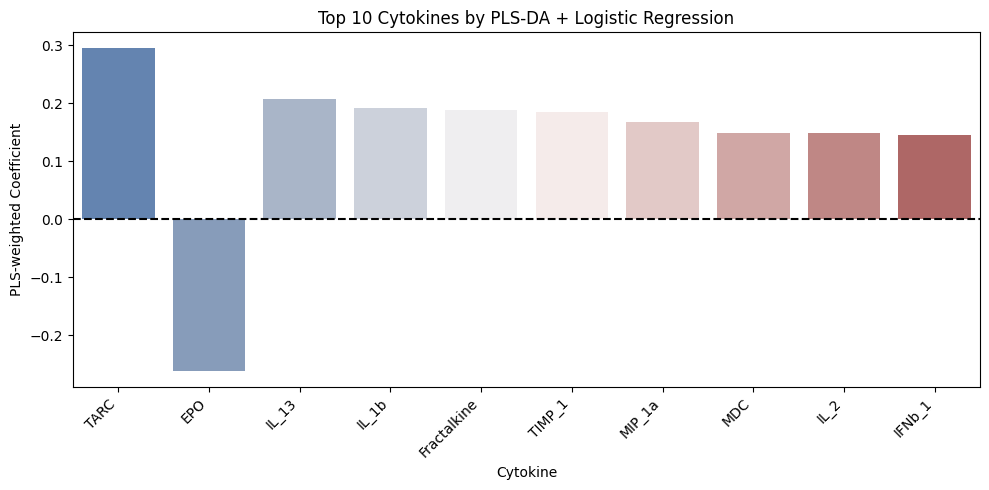

In [6]:
plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_df, x="Cytokine", y="FinalCoefficient", palette="vlag")
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel("PLS-weighted Coefficient")
plt.title("Top 10 Cytokines by PLS-DA + Logistic Regression")
plt.tight_layout()
plt.savefig(top10_feature_weights_cancerbio_t0.png, dpi=300)
plt.show()

In [4]:
top_10_df = top_10_df[["Cytokine", "FinalCoefficient", "Interpretation"]]
cv_mean, cv_std, equation, top_10_df, fig_path

(0.8642857142857142,
 0.09077332162242023,
 'GenotypeScore = 0.29·TARC + -0.26·EPO + 0.21·IL_13 + 0.19·IL_1b + 0.19·Fractalkine + 0.18·TIMP_1 + 0.17·MIP_1a + 0.15·MDC + 0.15·IL_2 + 0.15·IFNb_1',
                 Cytokine  FinalCoefficient Interpretation
 TARC                TARC          0.294084  Higher in Mut
 EPO                  EPO         -0.260864   Higher in WT
 IL_13              IL_13          0.206635  Higher in Mut
 IL_1b              IL_1b          0.192161  Higher in Mut
 Fractalkine  Fractalkine          0.187950  Higher in Mut
 TIMP_1            TIMP_1          0.184945  Higher in Mut
 MIP_1a            MIP_1a          0.166870  Higher in Mut
 MDC                  MDC          0.148945  Higher in Mut
 IL_2                IL_2          0.147677  Higher in Mut
 IFNb_1            IFNb_1          0.145251  Higher in Mut,
 'top10_feature_weights_cancerbio_t0.png')